<a href="https://colab.research.google.com/github/haydenclose/Cloud_based_Oil_Detection/blob/main/Automated_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloud Based Analysis of Oil Spills from Wrecks
This is a workflow on how to use Google Earth Engine (GEE) with Google Colab to identify and detect oil from shipwreck

Created By Hayden Close


#1 Installation and set-up of workspace

## 1.1 Connect to google drive
First of all connect your google drive account with colab so you can store inputs such as wreck locations and even scripts with functions in.

In [1]:
import google.colab.drive
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


##1.2 Install and import required libraries
Google Colab has lots of packages aready installed but some need to be installed via `!pip install name` and
`import name`

use `> /dev/null 2>&1; ` to supress outputs as lengthy and clog up the screen.



In [2]:
!pip install geemap > /dev/null 2>&1;                                                               # Need to install geeMap for easy iteractive plotting
!pip install geopandas > /dev/null 2>&1;                                                            # Install geopandas
!pip install plotly > /dev/null 2>&1;                                                               # Install Ploty for interactive graphs
import ee                                                                                           # To access the earth engine catalogue
import geemap                                                                                       # Imports the geeMap package into environment
import geopandas                                                                                    # Makes working with geospatial data in python easier
import pandas as pd                                                                                 # Useful package to read/export csv's etc...
import ipyleaflet                                                                                   # Needed for interactive plotting
import ipywidgets as widgets                                                                        # Way to have widgets onto geemaps
import math                                                                                         # Used in the gammafilter function
import plotly.express as px                                                                         # Used to plot the spills over time or the values from a line
import os
import requests
from typing import Union, List
from PIL import Image
#import io
import glob
print('Libraries installed')


Libraries installed


##1.3 Download functions file

If you havent already, download the python file with all the functions to run the tools.
The below codes downloads the file with from GitHib with the latest updates. See the script for documentation of the various functions.


In [3]:
!wget https://raw.githubusercontent.com/haydenclose/Cloud_based_Oil_Detection/main/Cloud_Based_Oil_Tools.ipynb
%run '/content/Cloud_Based_Oil_Tools.ipynb'

--2023-08-29 09:16:53--  https://raw.githubusercontent.com/haydenclose/Cloud_based_Oil_Detection/main/Cloud_Based_Oil_Tools.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90742 (89K) [text/plain]
Saving to: ‘Cloud_Based_Oil_Tools.ipynb’

Cloud_Based_Oil_Too 100%[===================>]  88.62K  --.-KB/s    in 0.01s   

2023-08-29 09:16:53 (6.32 MB/s) - ‘Cloud_Based_Oil_Tools.ipynb’ saved [90742/90742]



##1.4 Autenticate Earth Engine servers
To access the imagery catalogues you are required to autenticate yourself via your google account. To do this run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell. Authorisation last a week but sometimes need doing again if refreshed.

In [4]:
# Trigger the authentication flow.. Only need to do once a week
ee.Authenticate()

# Initialize the library
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=ksSvBxkfr88VuHzdrPNeC7dSeXpuSYBy3Qp1QhyOkFU&tc=nkQAjnuoSYMbOAzM923LcOMNoxZGSZHUIMGc61CW3N4&cc=ghiT4Tey-tp7-Yhd6qFqNUceM1xAwl1tn9fHUoLfVUI

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BUwPHdihA2BLAczAn-AkGB6SYCoQndbBwdCGtaqxtSzAimnLTQSoy8

Successfully saved authorization token.


# 2 Set up mapping parameters
Run the below `SetUp()` to generate the options to tailor the mapping.

1.   Drop down of pre-dertermined wrecks from an CSV that should be uploaded to your google drive. Dont place within a folder.
2.   Select the start date, either type it or click the calendar icon to select the date.
3.   Select the end date, either type it or click the calendar icon to select the date.
4.   Click the satellites that you wish to use.
      *   SENTINEL-1 - Only uses this satellite in the tool that uses Synthetic-aperture radar (SAR) that is not affected by cloud cover.
      *   SENTINEL-2 - Only uses visibile light with multispectral sensors but cannot see through clouds.
      *   BOTH - Uses both satellites in the tool.

5.   Select the orbit pass of the SENTINEL-1 satallite whether you want to use ascending, descending or both.

6.   Select the maximum cloud percentage. Unless lots of cloud, 100% recommend as the area of interest may not actually be covered.
7.   Select the pixel dilation factor, expands the selected pixels from the threshold by this number
8.   Removes objects that have a total number of pixels smaller than this number.















In [5]:
SetUp()

Dropdown(description='Wreck:', index=2, options=('SS DERBENT', 'HMS PRINCE OF WALES', 'HMS REPULSE', 'RFA WAR …

DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

RadioButtons(description='Satellites:', index=2, options=('SENTINEL-1', 'SENTINEL-2', 'BOTH'), value='BOTH')

RadioButtons(description='Sentinel-1 Orbit Pass:', index=1, options=('ASCENDING', 'DESCENDING', 'BOTH'), value…

IntSlider(value=100, description='Max cloud%', layout=Layout(width='400px'))

IntSlider(value=3, description='Dilation factor', layout=Layout(width='400px'), max=30)

IntSlider(value=250, description='Pixel Filter', layout=Layout(width='400px'), max=1000)

# 3 Segment Anything Tool

***SUPER COMPUTATIONAL EFFORT REQUIRED. CAN BE PROGRESSED WITH PAID RESOURCES.***

link to GitHub [Segment-geospatial](https://github.com/opengeos/segment-geospatial?s=03 )

In [7]:
%pip install segment-geospatial leafmap localtileserver > /dev/null 2>&1;
%pip install rasterstats > /dev/null 2>&1;
import os
import leafmap
import localtileserver
import io
import requests
import ee
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff

In [8]:
CreateTimeLapse()

FloatSlider(value=0.25, description='FPS', layout=Layout(width='400px'), max=1.0, min=0.1, step=0.05)

IntSlider(value=2700, description='Resolution', layout=Layout(width='400px'), max=3000, min=500, step=50)

Button(description='Run TimeLapse', style=ButtonStyle())

Get image collections

In [9]:
out_dir = '/content'
Wrecks = pd.read_excel('/content/drive/MyDrive/Wreck Database_V2.4.xls')                            # Load in the wreck list
Lat = pd.to_numeric(Wrecks.loc[Wrecks['Wreck_ID'] == WRKdropdown.value]['Latitude'])                # Get the latitude of selected wreck
Lon = Wrecks.loc[Wrecks['Wreck_ID'] == WRKdropdown.value]['Longitude']                              # Get the longitude of selected wreck
geom = ee.Geometry.Point(Lon.iloc[0],Lat.iloc[0]);                                                  # Loction of chosen wreck

  ## Get the imageCollection, s1, s2 or both then combine
if SatelliteNo.value == 'SENTINEL-1' or SatelliteNo.value == 'BOTH':                                # If to see if create feature collection with S1 or both
    S1ImgCol = (ee.ImageCollection('COPERNICUS/S1_GRD').                                            # Selects the Sentinel 1 image collection
      filterDate(str(StartDate.value), str(EndDate.value)).                                         # Selects only the dates from time period chosen above
      filterMetadata('instrumentMode', 'equals', 'IW').                                             # Selects the instrument mode that we want
      filter(ee.Filter.eq('orbitProperties_pass', str(orbit.value))).                               # Selects the orbit path we want
      filterBounds(geom))                                                                           # Selects only images that our wreck is contained within
    S1ImgCol = S1ImgCol.filter(ee.Filter.listContains('system:band_names', 'VV'))                   # Only selects VV band as missing in some images
    S1ImgCol = S1ImgCol.map(add_S1_date)                                                            # Adds the image date to image metadata in easy way to read

if SatelliteNo.value == 'SENTINEL-2' or SatelliteNo.value == 'BOTH':                                # If to see if create feature collection with S2 or both
   S2ImgCol = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED').                                      # Selects the Sentinel 2 image collection
     filterDate(str(StartDate.value), str(EndDate.value)).                                          # Selects only the dates from time period chosen above
     filterBounds(geom).                                                                            # Selects only images that our wreck is contained within
     filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', max_cloud_cover.value))                 # Filter image collection by cloud cover
    ## Method of skipping duplicate images
   ImgList = ee.ImageCollection(S2ImgCol).toList(99999)                                             # Get the imageCollection as a list
   date_string = '1066-01-01'                                                                       # Store the previous date, use really old date here at start
   count = int(S2ImgCol.size().getInfo())                                                           # Get number of images
   for i in range(0, count):                                                                        # Loop through the images
     PrevDate = date_string                                                                         # Store previous date
     img = ee.Image(ee.List(ImgList).get(i))                                                        # Get the next image in the list
     IMgdate = img.date()                                                                           # Get the acquisition date of the image
     date_string = IMgdate.format('YYYY-MM-dd').getInfo()                                           # Format the date as a string
     if date_string == PrevDate:                                                                    # If image dates the same
       image_id = ee.Image(img).getString('system:index').getInfo()                                 # Get new image date
       S2ImgCol = S2ImgCol.filter(ee.Filter.neq('system:index', image_id))                          # Remove the duplicate
   S2ImgCol = S2ImgCol.map(add_S2_date)                                                             # Add the image date to the metadata in an easy way to read

if SatelliteNo.value == 'BOTH':                                                                     # If both S1 and S2 combine collections
   ImageCol = S1ImgCol.merge(S2ImgCol)                                                              # Merge ImageCollections, note raw S1
   ImageCol = ImageCol.sort("Date")                                                                 # Order images by Date
elif SatelliteNo.value == 'SENTINEL-1':                                                             # Create collections based just on S1
   ImageCol = S1ImgCol                                                                              # ImageCollection = S1
elif  SatelliteNo.value == 'SENTINEL-2':                                                            # Create collections based just on S2
   ImageCol = S2ImgCol                                                                              # ImageCollection = S2



In [184]:
Map = geemap.Map()
point = ee.Geometry.Point(3.620619, 104.345181)
dist = 0.05
roi = ee.Geometry.BBox(Lon.iloc[0] - dist, Lat.iloc[0]- dist,Lon.iloc[0]+ dist, Lat.iloc[0] +dist)
Img = ImageCol.first().select('VV').clip(roi)
Map.addLayer(Img, {'bands':'VV', 'min':-25, 'max':5} , 'NAIP')
Map.centerObject(Img)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [11]:
geemap.ee_to_geotiff(
    Img, 'EE_image.tif', resolution=5, vis_params={'bands':'VV', 'min':-25, 'max':5})

Downloaded image 34/36
Downloaded image 35/36
Downloaded image 36/36
Saving GeoTIFF. Please wait...
Image saved to EE_image.tif


In [12]:
points_per_batch = widgets.IntSlider(value = 8,                                                  # Default value
                                      min = 0,                                                      # Minimum value
                                      max = 50,                                                    # Maximum value
                                      step = 1,                                                     # Incremental step
                                      description = 'Points Per Batch',                                   # Description of the slider
                                      readout = True,                                               # Provides the value on screen
                                      orientation = 'horizontal',                                   # Can be horizontal or vertical
                                      layout=widgets.Layout(width='400px'))                         # Size of widget
pred_iou_thresh = widgets.FloatSlider(value = 0.5,                                                           # Value to dilate each pixel by
                                      min = 0.1,                                                      # Min dilation value
                                      max = 1.0,                                                     # Maximum dilation value
                                      step = 0.1,                                                     # Incremental step
                                      description = 'pred_iou',                              # Description of the slider
                                      readout = True,                                               # Prints the slider value
                                      orientation = 'horizontal',                                   # Can be horizontal or vertical
                                      layout=widgets.Layout(width='400px'))                         # Size of widget
stability_score_thresh = widgets.FloatSlider(value = 0.8,                                                      # Removes polygons less than this size
                                      min = 0.1,                                                      # Min pixel filter size
                                      max = 1.0,                                                   # Max pixel filter size
                                      step = 0.1,                                                     # Incremental step
                                      description = 'stability score',                                 # Description of the slider
                                      readout = True,                                               # Prints the slider value
                                      orientation = 'horizontal',                                   # Can be horizontal or vertical
                                      layout=widgets.Layout(width='400px'))                         # Size of widget
display(points_per_batch,pred_iou_thresh,stability_score_thresh  ) # Returns the widgets

IntSlider(value=8, description='Points Per Batch', layout=Layout(width='400px'), max=50)

FloatSlider(value=0.5, description='pred_iou', layout=Layout(width='400px'), max=1.0, min=0.1)

FloatSlider(value=0.8, description='stability score', layout=Layout(width='400px'), max=1.0, min=0.1)

In [19]:
#my_kwargs = {'pred_iou_thresh': pred_iou_thresh.value, 'pred_iou_thresh': points_per_batch.value,'stability_score_thresh':stability_score_thresh.value}

#my_kwargs2 = {'points_per_batch': 8,'pred_iou_thresh': 0.5,'stability_score_thresh':0.8}
my_kwargs = {'pred_iou_thresh': 0.6,'stability_score_thresh':0.8}

In [20]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint='sam_vit_h_4b8939.pth',
    sam_kwargs=my_kwargs
)

In [21]:
image = '/content/EE_image.tif'
mask = 'polygons.tif'
sam.generate(image, output=mask, foreground=True, unique=True)

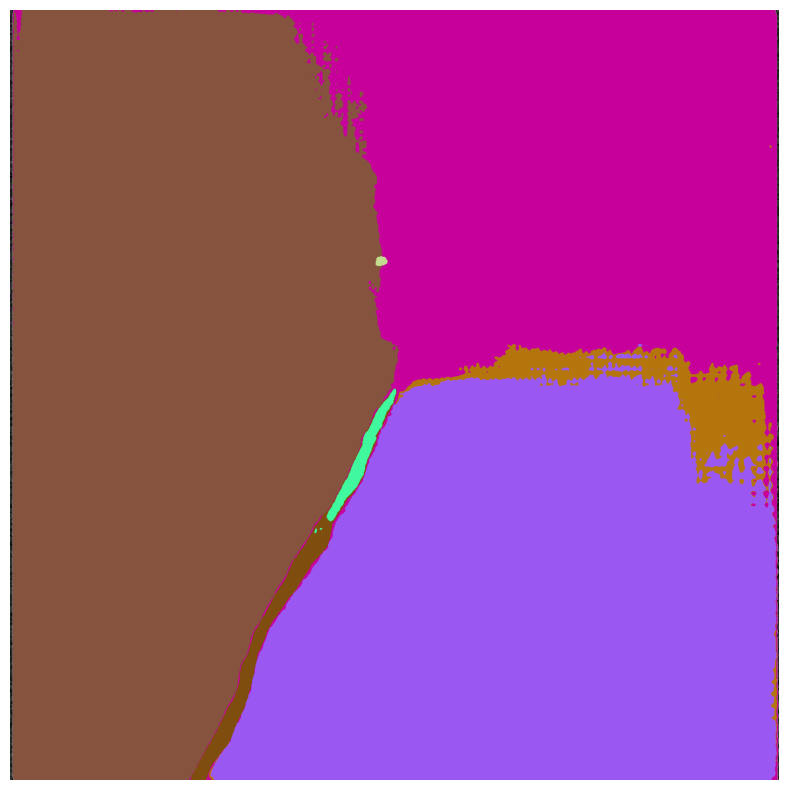

In [22]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")


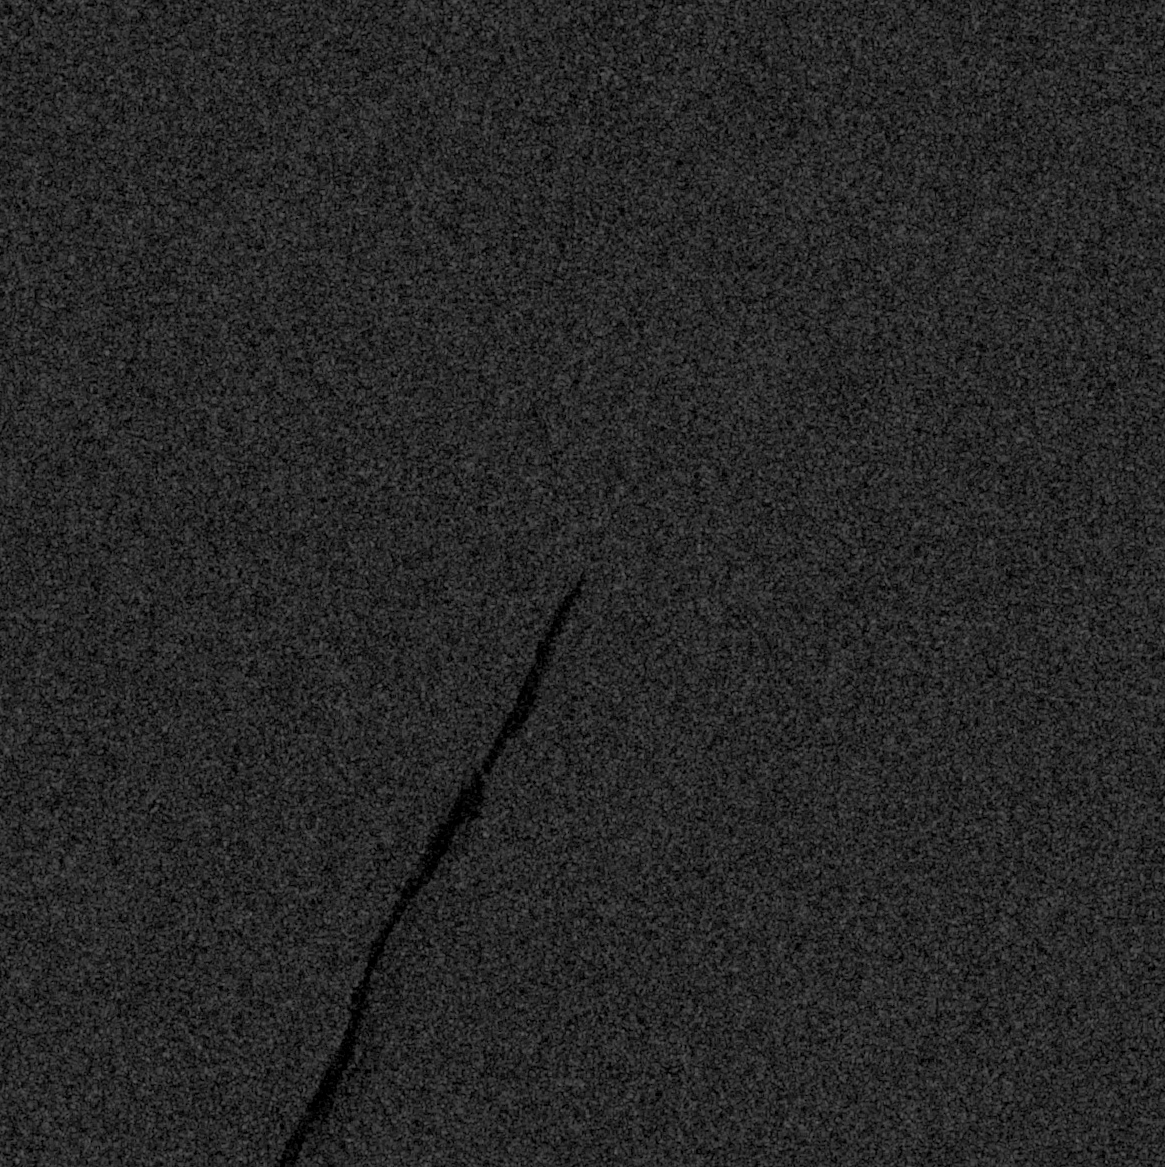
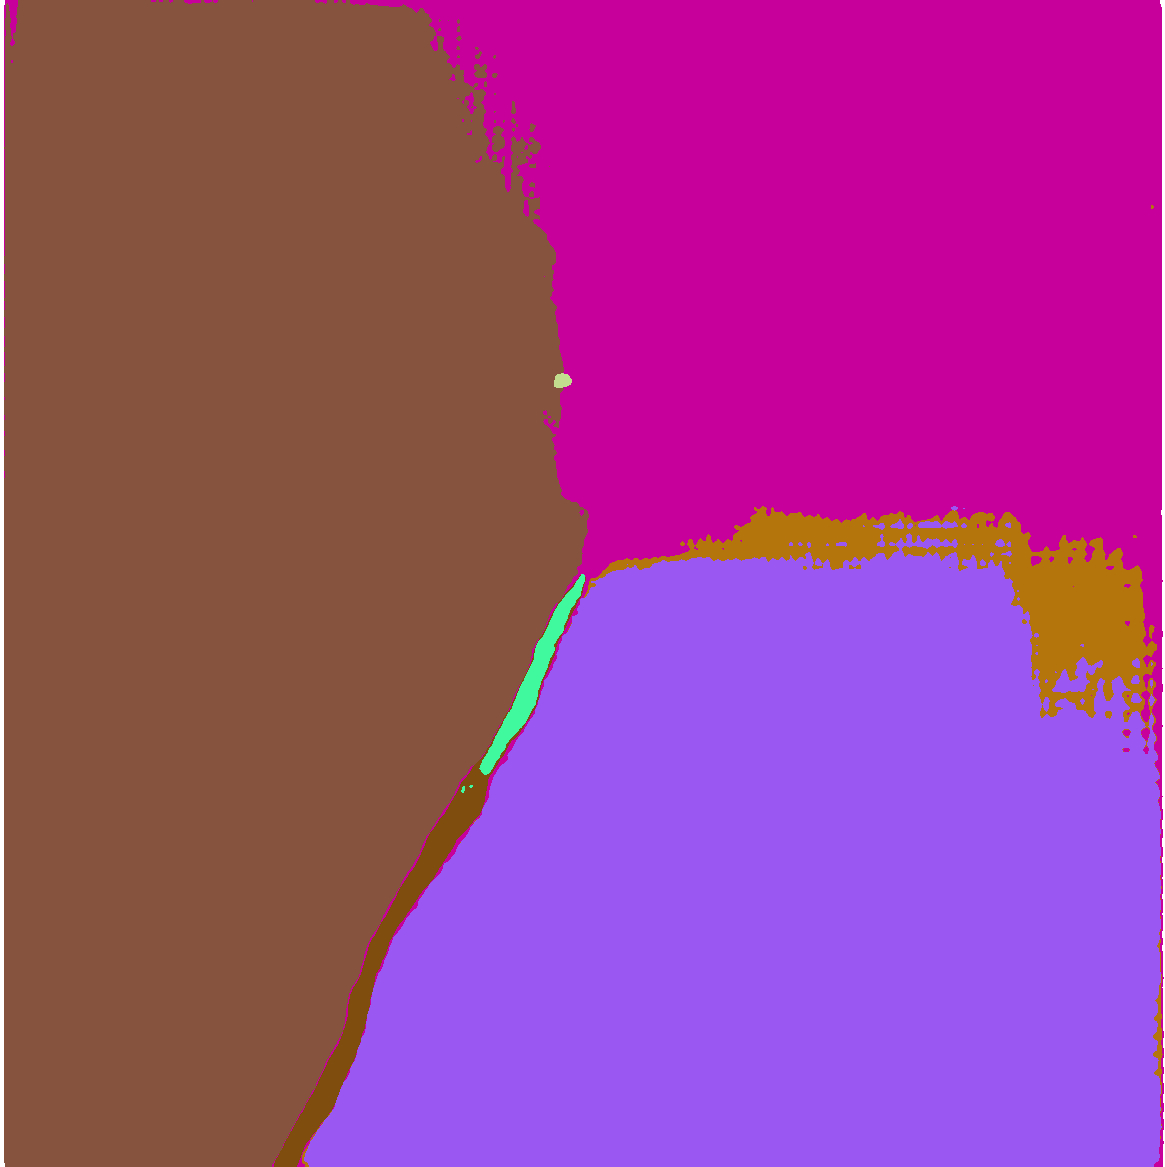

In [24]:
leafmap.image_comparison(
    image,
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

In [172]:
shpfle = f"/content/{WRKdropdown.value}_Raw_Segmentation.shp"
sam.raster_to_vector('annotations.tif', shpfle )

In [28]:
vector = "segment.gpkg"
sam.tiff_to_gpkg("annotations.tif", vector, simplify_tolerance=None)

In [176]:
import geemap
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from google.colab import drive

# define the path to the shapefile on Google Drive
shapefile_path = f"/content/{WRKdropdown.value}_Raw_Segmentation.shp"

# read the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# define the path to the raster file
raster_path = '/content/EE_image.tif'

# create a new column to store the mean pixel values
gdf['mean_value'] = np.nan

# open the raster file
with rasterio.open(raster_path) as src:
    # iterate over the polygons in the GeoDataFrame
    for i, row in gdf.iterrows():
        # get the geometry of the current polygon
        geom = row.geometry

        # extract the pixel values within the polygon
        out_image, out_transform = mask(src, [geom], crop=True)
        pixel_values = out_image[0]

        # calculate the mean pixel value within the polygon
        mean_value = np.mean(pixel_values)

        # store the mean value in the new column
        gdf.at[i, 'mean_value'] = mean_value

# convert the updated GeoDataFrame to a shapefile and save it to disk
MeansOfSAM = f"/content/{WRKdropdown.value}_Mean_Values_of_Segmentation.shp"
gdf.to_file(MeansOfSAM)

# convert the shapefile to an ee.FeatureCollection object
Polygons = geemap.shp_to_ee(MeansOfSAM)



In [178]:
myFilter = ee.Filter.lt('mean_value', 5)

# Apply the filter to the feature collection
filteredPolygons = Polygons.filter(myFilter)

stats = filteredPolygons.reduceColumns(ee.Reducer.minMax(), ['mean_value'])

# get the min and max values from the result
min_value = stats.get('min').getInfo()
max_value = stats.get('max').getInfo()


4.993079584775087

In [183]:
Map = geemap.Map()
point = ee.Geometry.Point(3.620619, 104.345181)
dist = 0.05
roi = ee.Geometry.BBox(Lon.iloc[0] - dist, Lat.iloc[0]- dist,Lon.iloc[0]+ dist, Lat.iloc[0] +dist)
FirstImg = ImageCol.first().select('VV').clip(roi)
Map.addLayer(FirstImg, {'bands':'VV', 'min':-25, 'max':5} , 'NAIP')
Map.centerObject(FirstImg)
Map
vis_params = {
    'color': '000000',
    'colorOpacity': 1,
    'pointSize': 3,
    'pointShape': 'circle',
    'width': 2,
    'lineType': 'solid',
    'fillColorOpacity': 0.66,
}
palette = 'FF0000'
MergedPolygons = ee.Geometry.MultiPolygon([])

# Iterate over the features in the feature collection
for feature in filteredPolygons.getInfo()['features']:
    # Get the geometry of the current feature
    geometry = ee.Geometry(feature['geometry'])
        # Apply the error margin to the geometry
    geometry = geometry.buffer(1)

    # Compute the union of the current geometry and the accumulated union
    MergedPolygons = MergedPolygons.union(geometry)
feature = ee.Feature(MergedPolygons)
MergedPolygons = ee.FeatureCollection([feature])

def add_Date(feature):
    # Compute the name as the first 3 characters of the STATEFP property
    #name = feature.getString('STATEFP').slice(0, 3)

    # Return a new feature with the name property added
    return feature.set('Date', '10-10_2023')

def add_Area(feature):
    spillaream2 = MergedPolygons.geometry().area(maxError = 1).getInfo()
    return feature.set('Area', spillaream2)


# Map the add_name function over the feature collection
MergedPolygons = MergedPolygons.map(add_Date)
MergedPolygons = MergedPolygons.map(add_Area)

Map.add_styled_vector(
    MergedPolygons, column="Date", palette=palette, layer_name="Styled vector", **vis_params
)
Map
img
#MergedPolygons.geometry().area(maxError = 1).getInfo()

NameError: ignored

In [ ]:
shp

# DONT DELETE
This downloads the GEOtiff with bands to extract the data.

In [ ]:
# A Sentinel-2 surface reflectance image.
FirstImg = ImageCol.first().select('VV')
dist = 0.05
roi = ee.Geometry.BBox(Lon.iloc[0] - dist, Lat.iloc[0]- dist,Lon.iloc[0]+ dist, Lat.iloc[0] +dist)
# A small region within the image.
#region = ee.Geometry.BBox(-122.0859, 37.0436, -122.0626, 37.0586)

# Multi-band GeoTIFF file.
url = FirstImg.getDownloadUrl({
    'bands': ['VV'],
    'region': roi,
    'scale': 5,
    'format': 'GEO_TIFF'
})
response = requests.get(url)
with open('Repulse_Scale_5.tif', 'wb') as fd:
  fd.write(response.content)

# EXAMPLES DO NOT DELETE

on how to download GEE images

In [ ]:
"""Demonstrates the ee.Image.getDownloadURL method."""

import io
import requests

# A Sentinel-2 surface reflectance image.
img = ee.Image('COPERNICUS/S2_SR/20210109T185751_20210109T185931_T10SEG')

# A small region within the image.
region = ee.Geometry.BBox(-122.0859, 37.0436, -122.0626, 37.0586)

# Image chunk as a NumPy structured array.
import numpy
url = img.getDownloadUrl({
    'bands': ['B3', 'B8', 'B11'],
    'region': region,
    'scale': 20,
    'format': 'NPY'
})
response = requests.get(url)
data = numpy.load(io.BytesIO(response.content))
print(data)
print(data.dtype)

# Single-band GeoTIFF files wrapped in a zip file.
url = img.getDownloadUrl({
    'name': 'single_band',
    'bands': ['B3', 'B8', 'B11'],
    'region': region
})
response = requests.get(url)
with open('single_band.zip', 'wb') as fd:
  fd.write(response.content)

# Multi-band GeoTIFF file wrapped in a zip file.
url = img.getDownloadUrl({
    'name': 'multi_band',
    'bands': ['B3', 'B8', 'B11'],
    'region': region,
    'scale': 20,
    'filePerBand': False
})
response = requests.get(url)
with open('multi_band.zip', 'wb') as fd:
  fd.write(response.content)

# Band-specific transformations.
url = img.getDownloadUrl({
    'name': 'custom_single_band',
    'bands': [
        {'id': 'B3', 'scale': 10},
        {'id': 'B8', 'scale': 10},
        {'id': 'B11', 'scale': 20}
    ],
    'region': region
})
response = requests.get(url)
with open('custom_single_band.zip', 'wb') as fd:
  fd.write(response.content)

# Multi-band GeoTIFF file.
url = img.getDownloadUrl({
    'bands': ['B3', 'B8', 'B11'],
    'region': region,
    'scale': 20,
    'format': 'GEO_TIFF'
})
response = requests.get(url)
with open('multi_band.tif', 'wb') as fd:
  fd.write(response.content)